#Protein Binding Energy Estimator (PBEE) - Colab Version



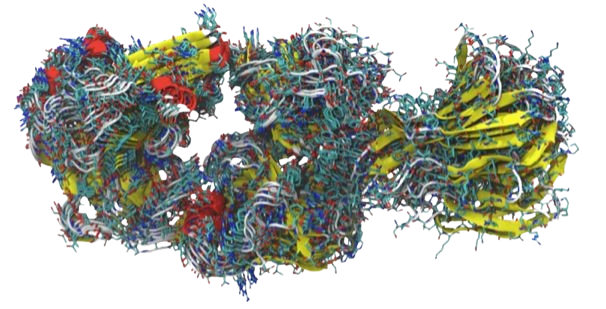


**PBEE** is an **easy-to-use pipeline** written in Python3 that uses a **ML model based on Rosetta descriptors** to **predict the free energy of binding** of **protein-protein complexes**. And now, It is available on **Google Colab**.

**Check out [here](https://github.com/chavesejf/PBEE) our PBEE page on Github.**


[Elton J. F. Chaves, João Sartori, Whendel M. Santos, Carlos H. B. Cruz, Emmanuel N. Mhrous, Manassés F. Nacimento-Filho, Matheus V. F. Ferraz and Roberto D. Lins. **Estimating Absolute Protein–Protein Binding Free Energies by a Super Learner Model**. *Journal of Chemical Information and Modeling*, 2025.](https://pubs.acs.org/doi/10.1021/acs.jcim.4c01641)

In [ ]:
# @title Install all the dependecies
%%capture
!git clone https://github.com/chavesejf/PBEE.git
!pip install pyrosetta-installer
!python -c 'import pyrosetta_installer; pyrosetta_installer.install_pyrosetta()'
import gdown
folder_id = "1cWTJ9Z5ylv5ApoAdJIvEJsTpUoySNQs8"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)
!mkdir /content/PBEE/trainedmodels
!mv /content/v1.1 /content/PBEE/trainedmodels
!pip install --upgrade numpy
!pip install --upgrade scikit-learn
!pip install xgboost==2.0.1

In [ ]:
!pip install --upgrade setuptools wheel cython


In [ ]:
!pip install scikit-learn==1.3.2




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 131.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.3.5 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.3.5 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 1.3.5 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.3.5 

In [ ]:
# @title Upload the pdb file
from google.colab import files
import os
import shutil

# Multiple file upload function
uploaded = files.upload()

# Directory
destination_path = "/content/PBEE/tests/pdbs/selectpdbs"
os.makedirs(destination_path, exist_ok=True)

# List to keep the names of saved files
pdb_files = []

if uploaded:
    for file_name in uploaded.keys():
        # Check if the file has a .pdb extension
        if not file_name.endswith('.pdb'):
            print(f"\033[91mWarning: The uploaded file '{file_name}' does not have a .pdb extension. It will not be saved.\033[0m")
            os.remove(file_name)
        else:
            # Full path to save the file
            target_path = os.path.join(destination_path, file_name)
            shutil.move(file_name, target_path)
            pdb_files.append(file_name)  # Salvar o nome do arquivo na lista
            print(f"\033[92mThe file '{file_name}' was uploaded and saved successfully")
else:
    print("\033[91mNo files were uploaded. Please try again.\033[0m")

# Displaying the names of saved files
print("\033[94mFiles saved:\033[0m", pdb_files)

Saving hCBX7_H3.pdb to hCBX7_H3.pdb
The file 'hCBX7_H3.pdb' was uploaded and saved successfully
Files saved: ['hCBX7_H3.pdb']


In [ ]:
# @title Choose the settings and run
partner_1 = "A" # @param {"type":"string"}
partner_2 = "B" # @param {"type":"string"}
# @markdown **Note**: PBEE **renames** the **chains of the complex starting with A, B, C** and so on. Therefore, if you use the **HL_W interface**, PBEE will **rewrite it as follows: AB_C**.
partner_1 = partner_1.upper()
partner_2 = partner_2.upper()
frcmod_struct = False # @param {"type":"boolean"}
# @markdown **frcmod_struct**: Ignores warning messages about structure(s) with gap(s).
frcmod_scores = False # @param {"type":"boolean"}
# @markdown **frcmod_scores**: Ignores warning messages about low-quality descriptors.
ion_dist_cutoff = 2 # @param {"type":"number"}
# @markdown **Cutoff distance (Å)**: Detects ion(s) close to the protein atoms (default= 2 Å).
mlengine = "sl" # @param ["sl","lr","en","sv","dt","kn","ad","bg","rf","et","xb"]
# @markdown **mlengine**: Defines the machine learning engine (default: sl).

# @markdown Our algorithms:
# @markdown - **sl** (Superlearner)
# @markdown - **lr** (Logarithmic Regression)
# @markdown - **en** (Elastic Net)
# @markdown - **sv** (SVR)
# @markdown - **dt** (Decision Tree)
# @markdown - **kn** (KNeighbors)
# @markdown - **ad** (AdaBoost)
# @markdown - **bg** (Bagging)
# @markdown - **rf** (Random Forest)
# @markdown - **et** (ExtraTrees)
# @markdown - **xb** (XGBRegressor)

from IPython.display import display, HTML

#Default mode of frcmods
if frcmod_struct == False and frcmod_scores == False:
  #Some possible user erros (blank or unavailable outputs in settings)
  if ion_dist_cutoff == None:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no ion_dist_cutoff. Please, input a value! </span>"))
  elif ion_dist_cutoff < 0:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable ion_dist_cutoff. Please, input a positive value!</span>"))
  elif mlengine not in ["sl", "lr", "en", "sv", "dt", "kn", "ad", "bg", "rf", "et", "xb"]:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable mlengine. Please, input the models described in the details!</span>"))
  elif mlengine == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no mlegine. Please, input an avaiable one! </span>"))
  elif partner_1 == "" or partner_2 == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Empty partners. Please, fill in them correctly!</span>"))

  #Possible output combinations
  elif ion_dist_cutoff != 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --ion_dist_cutoff {ion_dist_cutoff} --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff != 2 and mlengine == "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --ion_dist_cutoff {ion_dist_cutoff}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff == 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  else:
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb

#frcmod_struct activated only
if frcmod_struct == True and frcmod_scores == False:
   #Some possible user erros (blank or unavailable outputs in settings)
  if ion_dist_cutoff == None:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no ion_dist_cutoff. Please, input a value! </span>"))
  elif ion_dist_cutoff < 0:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable ion_dist_cutoff. Please, input a positive value!</span>"))
  elif mlengine not in ["sl", "lr", "en", "sv", "dt", "kn", "ad", "bg", "rf", "et", "xb"]:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable mlengine. Please, input the models described in the details!</span>"))
  elif mlengine == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no mlegine. Please, input an avaiable one! </span>"))
  elif partner_1 == "" or partner_2 == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Empty partners. Please, fill in them correctly!</span>"))

  #Possible output combinations
  elif ion_dist_cutoff != 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct --ion_dist_cutoff {ion_dist_cutoff} --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff != 2 and mlengine == "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct --ion_dist_cutoff {ion_dist_cutoff}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff == 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  else:
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb

#frcmod_scores activated only
if frcmod_struct == False and frcmod_scores == True:
  #Some possible user erros (blank or unavailable outputs in settings)
  if ion_dist_cutoff == None:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no ion_dist_cutoff. Please, input a value! </span>"))
  elif ion_dist_cutoff < 0:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable ion_dist_cutoff. Please, input a positive value!</span>"))
  elif mlengine not in ["sl", "lr", "en", "sv", "dt", "kn", "ad", "bg", "rf", "et", "xb"]:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable mlengine. Please, input the models described in the details!</span>"))
  elif mlengine == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no mlegine. Please, input an avaiable one! </span>"))
  elif partner_1 == "" or partner_2 == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Empty partners. Please, fill in them correctly!</span>"))

  #Possible output combinations
  elif ion_dist_cutoff != 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_scores --ion_dist_cutoff {ion_dist_cutoff} --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff != 2 and mlengine == "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_scores --ion_dist_cutoff {ion_dist_cutoff}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff == 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_scores --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  else:
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_scores
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb

#both of frcmodes activated
if frcmod_struct == True and frcmod_scores == True:
  #Some possible user erros (blank or unavailable outputs in settings)
  if ion_dist_cutoff == None:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no ion_dist_cutoff. Please, input a value! </span>"))
  elif ion_dist_cutoff < 0:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable ion_dist_cutoff. Please, input a positive value!</span>"))
  elif mlengine not in ["sl", "lr", "en", "sv", "dt", "kn", "ad", "bg", "rf", "et", "xb"]:
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Unavailable mlengine. Please, input the models described in the details!</span>"))
  elif mlengine == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: There is no mlegine. Please, input an avaiable one! </span>"))
  elif partner_1 == "" or partner_2 == "":
    display(HTML(f"<span style='color: red; font-size: 14px; font-weight: bold;'>Warning: Empty partners. Please, fill in them correctly!</span>"))

  #Possible output combinations
  elif ion_dist_cutoff != 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --odir /content/PBEE/tests --frcmod_struct --frcmod_scores --ion_dist_cutoff {ion_dist_cutoff} --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff != 2 and mlengine == "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct --frcmod_scores --ion_dist_cutoff {ion_dist_cutoff}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  elif ion_dist_cutoff == 2 and mlengine != "sl" :
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct --frcmod_scores --mlengine {mlengine}
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb
  else:
    !python3 /content/PBEE/pbee.py --ipdb /content/PBEE/tests/pdbs/selectpdbs/*.pdb --partner1 {partner_1} --partner2 {partner_2} --odir /content/PBEE/tests --frcmod_struct --frcmod_scores
    !rm -rf /content/PBEE/tests/pdbs/selectpdbs/*.pdb


   Protein Engineering and Structural Genomic Group  
          Oswaldo Cruz Foundation - FIOCRUZ          
 -----------------------------------------------------

 ********* Protein Binding Energy Estimator **********

 Authors: Roberto Lins, Elton Chaves, and João Sartori
     DOI: 10.1021/acs.jcim.4c01641
 Version: v1.1

        mlengine: /content/PBEE/trainedmodels/v1.1/v1.1__SuperLearner.pkl
      output_dir: /content/PBEE/tests
        partner1: A
        partner2: B
 ion_dist_cutoff: 2
       structure: [0] /content/PBEE/tests/pdbs/selectpdbs/hCBX7_H3.pdb
            info: total structures: 1
        protocol: [0] /content/PBEE/tests/pdbs/selectpdbs/hCBX7_H3.pdb
        protocol: [0] total number of ions: 0
        protocol: [0] geometry optimization and interface analysis
protocols.simple_filters.ContactMolecularSurfaceFilter: Using residues for molecule surface (rosetta numbering):
protocols.simple_filters.ContactMolecularSurfaceFilter:   Target Surface: 1, 2, 3, 4, 5, 6, 7, 